In [93]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
from datetime import datetime
import tensorboard
%load_ext tensorboard


***TASK 1***
---------------------------------------

170498071/170498071 [==============================] - 6s 0us/step
[4]


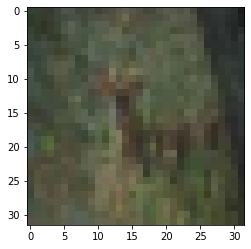

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_set = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 32, 32, 3]).astype(np.float32)/255, train_labels.reshape((-1,)).astype(np.int32))).shuffle(buffer_size=60000).batch(128).repeat()

test_set = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 32, 32, 3]).astype(np.float32)/255, test_labels.reshape((-1,)).astype(np.int32))).batch(128)
print(train_labels[10])
plt.imshow(train_images[10], cmap="Greys_r")
plt.show()

In [54]:
input_DenseNet = keras.Input(shape=(32, 32, 3))
print(input_DenseNet.shape)
print(input_DenseNet.dtype)

# input_DenseNet = layers.Conv2D(64, 3, activation="relu", padding="same")(input_DenseNet)
# input_DenseNet = layers.MaxPool2D(3, strides = 2 , padding="same")(input_DenseNet)
# Block 1
conv_1 = layers.Conv2D(64, 3, activation="relu", padding="same")(input_DenseNet)
conv_2 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv_1)
conv_3 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv_2)
# pool_1 = layers.MaxPool2D(3, strides = 1 , padding="same")(input_DenseNet)

# transition layer to reduce feature map size for Block 1
block_1 = layers.concatenate([conv_3, input_DenseNet])
block_1 = layers.Conv2D(64, 1, activation="relu", padding="same")(block_1)
output_block_1 = layers.AveragePooling2D(pool_size=(2, 2), strides = 2, padding="same")(block_1)


# Block 2
conv_4 = layers.Conv2D(64, 5, activation="relu", padding="same")(output_block_1)
conv_5 = layers.Conv2D(64, 5, activation="relu", padding="same")(conv_4)
conv_6 = layers.Conv2D(64, 5, activation="relu", padding="same")(conv_5)

# transition layer to reduce feature map size for Block 2
block_2 = tf.keras.layers.concatenate([conv_6, output_block_1])
block_2 = layers.Conv2D(64, 1, activation="relu", padding="same")(block_2)
output_block_2 = layers.AveragePooling2D(pool_size=(2, 2), strides = 2,  padding="same")(block_2)


# Block 3
conv_7 = layers.Conv2D(64, 5, activation="relu", padding="same")(output_block_2)
conv_8 = layers.Conv2D(64, 5, activation="relu", padding="same")(conv_7)
conv_9 = layers.Conv2D(64, 5, activation="relu", padding="same")(conv_8)

# transition layer to reduce feature map size for Block 2
block_3 = layers.concatenate([conv_9, output_block_2])
block_3 = layers.Conv2D(64, 1, activation="relu", padding="same")(block_3)
output_block_3 = layers.AveragePooling2D(pool_size=(2, 2), strides = 2, padding="same")(block_3)

# output layer
output = layers.GlobalAveragePooling2D()(output_block_3)
output_DenseNet = layers.Dense(10)(output)


model = keras.Model(input_DenseNet, output_DenseNet, name="DenseNet3Block")
model.summary()

(None, 32, 32, 3)
<dtype: 'float32'>
Model: "DenseNet3Block"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_287 (Conv2D)            (None, 32, 32, 64)   1792        ['input_47[0][0]']               
                                                                                                  
 conv2d_288 (Conv2D)            (None, 32, 32, 64)   36928       ['conv2d_287[0][0]']             
                                                                                                  
 conv2d_289 (Conv2D)            (None, 32, 32, 64)   36928       ['conv2d_288[0][0]']             
                                                

In [55]:
model.compile(optimizer='Adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= [tf.metrics.SparseCategoricalAccuracy()])
history = model.fit(train_images, train_labels, epochs=5, 
                    validation_data=(test_images,test_labels))

Epoch 1/5
1563/1563 [==============================] - 25s 15ms/step - loss: 1.6331 - sparse_categorical_accuracy: 0.4118 - val_loss: 1.2804 - val_sparse_categorical_accuracy: 0.5342
Epoch 2/5
1563/1563 [==============================] - 23s 15ms/step - loss: 1.0993 - sparse_categorical_accuracy: 0.6114 - val_loss: 0.9923 - val_sparse_categorical_accuracy: 0.6484
Epoch 3/5
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8838 - sparse_categorical_accuracy: 0.6913 - val_loss: 0.8407 - val_sparse_categorical_accuracy: 0.7069
Epoch 4/5
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7531 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.7449 - val_sparse_categorical_accuracy: 0.7444
Epoch 5/5
1563/1563 [==============================] - 23s 15ms/step - loss: 0.6533 - sparse_categorical_accuracy: 0.7752 - val_loss: 0.7725 - val_sparse_categorical_accuracy: 0.7479


In [56]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 6ms/step - loss: 0.7725 - sparse_categorical_accuracy: 0.7479


[0.7725191116333008, 0.7479000091552734]

***TASK 2***
-----------------------------------


In [79]:
# stereotypical train-step-with-function-annotation
optimizer = tf.optimizers.Adam()

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_acc_metric = tf.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images)
        xent = loss_fn(labels, logits)

    variables = model.trainable_variables
    gradients = tape.gradient(xent, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return xent, logits


def training_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images)
        xent = loss_fn(labels, logits)

    variables = model.trainable_variables
    gradients = tape.gradient(xent, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return xent, logits

@tf.function
def train_step_mlp(images, labels):
    with tf.GradientTape() as tape:
        logits = mlp_model(images)
        xent = loss_fn(labels, logits)

    variables = model.trainable_variables
    gradients = tape.gradient(xent, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return xent, logits


def training_step_mlp(images, labels):
    with tf.GradientTape() as tape:
        logits = mlp_model(images)
        xent = loss_fn(labels, logits)

    variables = model.trainable_variables
    gradients = tape.gradient(xent, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return xent, logits

In [76]:
train_steps = 2000
start = time.time()


print("with graph execution")

for step, (img_batch, lbl_batch) in enumerate(train_set):
    if step > train_steps:
        break
    xent, logits = train_step(img_batch, lbl_batch)

    if not step % 400:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Step no: {} | Loss: {} | Accuracy: {}".format(step, xent, acc))
        train_acc_metric.reset_states()

        stop = time.time()
        print("took {} seconds\n".format(stop-start))
        start = time.time()



with graph execution
Step no: 0 | Loss: 0.011516992002725601 | Accuracy: 0.9921875
took 0.15270543098449707 seconds

Step no: 400 | Loss: 0.02654046006500721 | Accuracy: 0.9921875
took 14.168830394744873 seconds

Step no: 800 | Loss: 0.001534186420030892 | Accuracy: 1.0
took 14.359786748886108 seconds

Step no: 1200 | Loss: 0.010468296706676483 | Accuracy: 1.0
took 14.46867299079895 seconds

Step no: 1600 | Loss: 0.002892036223784089 | Accuracy: 1.0
took 14.433529376983643 seconds

Step no: 2000 | Loss: 0.024464383721351624 | Accuracy: 0.9921875
took 14.202605962753296 seconds



In [73]:
train_steps = 2000

start = time.time()
print("without graph execution")

for step, (img_batch, lbl_batch) in enumerate(train_set):
    if step > train_steps:
        break
    
    xent, logits = training_step(img_batch, lbl_batch)

    if not step % 400:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Step no: {} | Loss: {} | Accuracy: {}".format(step, xent, acc))
        train_acc_metric.reset_states()

        stop = time.time()
        print("took {} seconds\n".format(stop-start))
        start = time.time()


without graph execution
Step no: 0 | Loss: 0.010850874707102776 | Accuracy: 0.9921875
took 0.1514277458190918 seconds

Step no: 400 | Loss: 0.01726371794939041 | Accuracy: 0.9921875
took 18.589876413345337 seconds

Step no: 800 | Loss: 0.0060083260759711266 | Accuracy: 1.0
took 18.509227991104126 seconds

Step no: 1200 | Loss: 0.07489652931690216 | Accuracy: 0.984375
took 18.445528984069824 seconds

Step no: 1600 | Loss: 0.004952406045049429 | Accuracy: 1.0
took 18.271588563919067 seconds

Step no: 2000 | Loss: 0.008561876602470875 | Accuracy: 1.0
took 18.33797001838684 seconds



***MLP with and without @tf.function***
-------------------------


In [81]:
mlp_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1.,input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

In [82]:
train_steps = 2000

start = time.time()
print("without graph execution")

for step, (img_batch, lbl_batch) in enumerate(train_set):
    if step > train_steps:
        break
    
    xent, logits = training_step(img_batch, lbl_batch)

    if not step % 400:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Step no: {} | Loss: {} | Accuracy: {}".format(step, xent, acc))
        train_acc_metric.reset_states()

        stop = time.time()
        print("took {} seconds\n".format(stop-start))
        start = time.time()


without graph execution
Step no: 0 | Loss: 0.014527734369039536 | Accuracy: 0.9921875
took 0.17173504829406738 seconds

Step no: 400 | Loss: 0.012718414887785912 | Accuracy: 0.9921875
took 19.13652801513672 seconds

Step no: 800 | Loss: 0.007301848381757736 | Accuracy: 1.0
took 18.45614790916443 seconds

Step no: 1200 | Loss: 0.004926498979330063 | Accuracy: 1.0
took 18.361228704452515 seconds

Step no: 1600 | Loss: 0.027607981115579605 | Accuracy: 0.984375
took 18.43343186378479 seconds

Step no: 2000 | Loss: 0.003116187173873186 | Accuracy: 1.0
took 18.3194899559021 seconds



In [98]:
train_steps = 2000
start = time.time()


print("with graph execution")

for step, (img_batch, lbl_batch) in enumerate(train_set):
    if step > train_steps:
        break
    # Set up logging.
    # stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    # logdir = 'logs/func/%s' % stamp
    # writer = tf.summary.create_file_writer(logdir)
    # tf.summary.trace_on(graph=True, profiler=True)

    xent, logits = train_step(img_batch, lbl_batch)

    if not step % 400:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Step no: {} | Loss: {} | Accuracy: {}".format(step, xent, acc))
        train_acc_metric.reset_states()

        stop = time.time()
        print("took {} seconds\n".format(stop-start))
        start = time.time()



with graph execution
Step no: 0 | Loss: 0.0007358271977864206 | Accuracy: 1.0
took 0.1582345962524414 seconds

Step no: 400 | Loss: 0.005741880740970373 | Accuracy: 1.0
took 14.379942655563354 seconds

Step no: 800 | Loss: 0.004001328255981207 | Accuracy: 1.0
took 14.569858074188232 seconds

Step no: 1200 | Loss: 0.07643134146928787 | Accuracy: 0.96875
took 14.381007432937622 seconds

Step no: 1600 | Loss: 0.002633417723700404 | Accuracy: 1.0
took 14.238472938537598 seconds

Step no: 2000 | Loss: 0.03343939408659935 | Accuracy: 0.984375
took 14.325185537338257 seconds

